In [41]:
%matplotlib inline
import time

import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt
from scipy.stats import mode

from clustiVAT import clustiVAT
from data_generate import data_generate
from distance2 import distance2
from iVAT import iVAT

In [42]:
total_no_of_points = 1000
clusters = 4
odds_matrix = np.array(
    [np.ceil(clusters*np.random.rand(clusters))]).astype(int)

colors_1 = np.array(cm.get_cmap().colors)
colors = np.zeros((clusters, 3))

for i in range(1, clusters+1):
    colors[i-1, :] = colors_1[int(
        np.ceil(max(colors_1.shape)*i/clusters)-1), :]

In [43]:
data_matrix_with_labels, mean_matrix, var_matrix = data_generate(
    number_of_clusters=clusters, odds_matrix=odds_matrix, total_no_of_points=total_no_of_points)

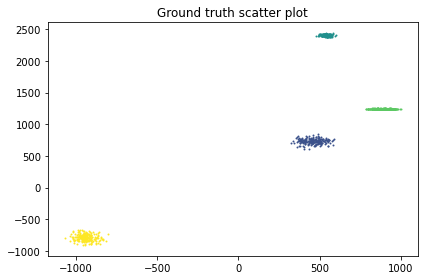

In [44]:
p1 = plt.figure(1)
plt.title(label="Ground truth scatter plot")
for i in range(0, clusters):
    cluster_index = np.array(np.where(data_matrix_with_labels[:, -1] == i))
    plt.scatter(data_matrix_with_labels[cluster_index, 0],
                data_matrix_with_labels[cluster_index, 1], marker='o', color=colors[i-1, :], s=0.9)

In [45]:
###################### CLUSTIVAT #########################

x = data_matrix_with_labels
n, p = x.shape

tic = time.time()

Pitrue = x[:, -1]
x = x[:, 0:-1]

cp = 10
ns = 300

rv, C, I, ri, cut, smp = clustiVAT(x, cp, ns)

x1, y1 = cut.shape
cut = cut.reshape((x1*y1,))
cuts, ind = -np.sort(-cut), np.argsort(-cut)
ind = np.sort(ind[0:clusters-1])

Pi = np.zeros((n,))
Pi[smp[I[ind[0]-2]]] = 1
Pi[smp[I[ind[-1]:-1]]] = clusters

for i in range(1, clusters-1):
    Pi[smp[I[ind[i-1]:ind[i]-1]]] = i

nsmp = np.setdiff1d(np.linspace(1, clusters, clusters, dtype=int), smp)
r = distance2(x[smp, :], x[nsmp, :])
s = np.argmin(r, axis=0)
Pi[nsmp] = Pi[smp[s]]

RiV, RV, reordering_mat = iVAT(rv, 1)

toc = time.time()
print("Time elapsed : ", str(toc-tic))


D:\SMOP\New folder (2)\MattoPy\clustiVAT\VAT.py:23: FutureWarning: in the future insert will treat boolean arrays and array-likes as boolean index instead of casting it to integer
  J = np.delete(J, J == J[j])
D:\SMOP\New folder (2)\MattoPy\clustiVAT\VAT.py:34: FutureWarning: in the future insert will treat boolean arrays and array-likes as boolean index instead of casting it to integer
  except ValueError:


Time elapsed :  0.3549962043762207


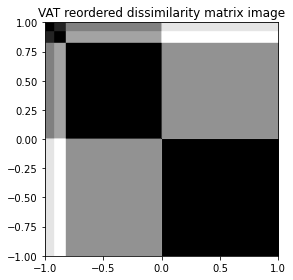

In [46]:
p2 = plt.figure(2)
plt.rcParams["figure.autolayout"] = True
plt.imshow(rv, cmap=cm.get_cmap('gray'), extent=[-1, 1, -1, 1])
plt.title(label="VAT reordered dissimilarity matrix image")
plt.show()

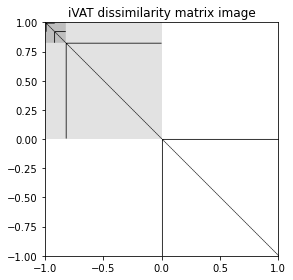

In [47]:
p3 = plt.figure(3)
plt.rcParams["figure.autolayout"] = True
plt.imshow(RiV, cmap=cm.get_cmap('gray'), extent=[-1, 1, -1, 1])
plt.title(label="iVAT dissimilarity matrix image")
plt.show()

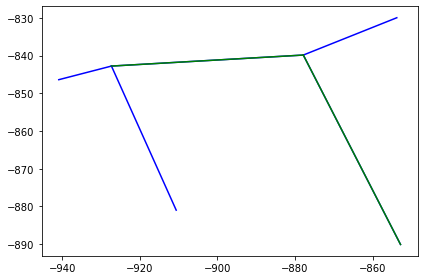

In [48]:
p4 = plt.figure(4)
for i in range(0, np.max(smp.shape)-1):
    x_cor = np.hstack((x[smp[I[i]], 0], x[smp[I[C[i]]], 0]))
    y_cor = np.hstack((x[smp[I[i]], 1], x[smp[I[C[i]]], 1]))
    plt.plot(x_cor, y_cor, 'b')

for i in range(np.max(ind.shape)):
    x_cor = np.hstack((x[smp[I[ind[i]]], 0], x[smp[I[C[ind[i]]]], 0]))
    y_cor = np.hstack((x[smp[I[ind[i]]], 1], x[smp[I[C[ind[i]]]], 1]))
    plt.plot(x_cor, y_cor, 'g')
    
plt.show()

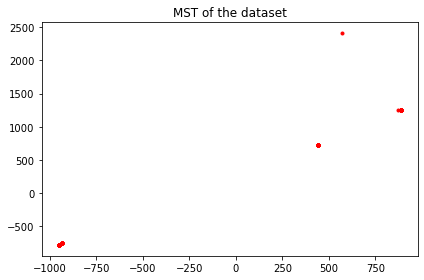

In [49]:
p5 = plt.figure(5)
plt.plot(x[I, 0], x[I, 1], 'r.')
plt.title(label="MST of the dataset")
plt.show()

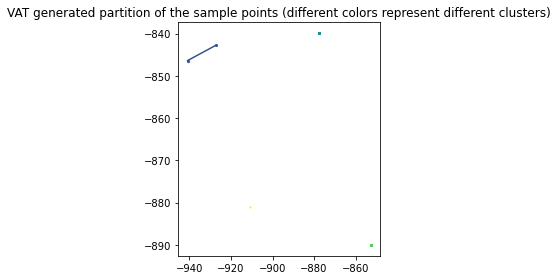

In [50]:
p6 = plt.figure(6)

for i in range(0, clusters):
    if i == 0:
        partition = I[0:ind[i]]
    elif i == clusters-1:
        partition = I[ind[i-1]:np.max(I.shape)]
    else:
        partition = I[ind[i-1]:ind[i]-1]

    plt.plot(x[smp[partition], 0], x[smp[partition], 1],
             marker='o', color=colors[i-1, :], markersize=1)

plt.title('VAT generated partition of the sample points (different colors represent different clusters)')
plt.show()

<ipython-input-52-750d4cd3b5fd>:32: FutureWarning: in the future insert will treat boolean arrays and array-likes as boolean index instead of casting it to integer
  index_remaining = np.delete(


Text(0.5, 1.0, 'VAT generated partition of the entire dataset (different colors represent different clusters)')

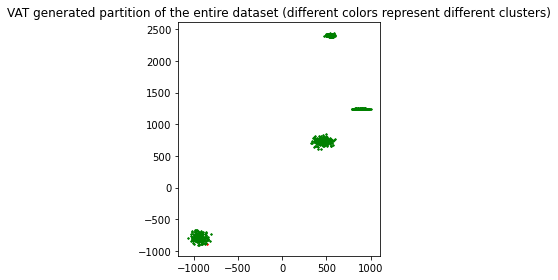

In [52]:
cluster_matrix_mod = np.zeros(data_matrix_with_labels.shape, dtype=int)
length_partition = np.zeros((clusters,), dtype=int)


for i in range(0, clusters):
    length_partition[i] = np.max(np.where(Pi == i)[0].shape)

length_partition_sort, length_partition_sort_idx = - \
    np.sort(-length_partition), np.argsort(-length_partition)
index_remaining = np.linspace(0, clusters-1, clusters, dtype=int)

for i in range(0, clusters):

    original_idx = length_partition_sort_idx[i]
    partition = np.where(Pi == original_idx)[0]
    proposed_idx = mode(Pitrue[partition]).mode

    if np.sum(index_remaining == proposed_idx) != 0:
        cluster_matrix_mod[np.where(Pi == original_idx)[0]] = proposed_idx
    else:
        try:
            cluster_matrix_mod[np.where(Pi == original_idx)[0]] = index_remaining[0]
        except:
            pass

    if type(index_remaining == proposed_idx) == bool:
        if (index_remaining == proposed_idx) is True:
            index_remaining = np.delete(
                index_remaining, index_remaining == proposed_idx)
    else:
        if (index_remaining == proposed_idx).shape[0] != 0:
            index_remaining = np.delete(
                index_remaining, index_remaining == proposed_idx)
            
p7 = plt.figure(7)
pst = np.linspace(0, clusters-1, clusters, dtype=int)
tst = ["red", "yellow", "blue", "green"]
for i in range(0, clusters):
    #cluster_matrix_unique = np.unique(cluster_matrix_mod)
    cluster_index = np.where(cluster_matrix_mod == pst[i])[0]
    plt.scatter(x[cluster_index, 0], x[cluster_index, 1],
                marker='o', color=tst[i], s=0.9)

plt.title('VAT generated partition of the entire dataset (different colors represent different clusters)')

In [53]:
crct_prct_clustivat = (
    (np.max(x.shape)-np.max(np.where(Pitrue-cluster_matrix_mod.T != 0)[0].shape))/np.max(x.shape))*100
print("crct_prct_clustivat : " + str(crct_prct_clustivat))

crct_prct_clustivat : -79.7
